# 7.Adaboost算法

In [2]:
from numpy import *

## 7.1.单层决策树
### 7.1.1.读取数据

In [3]:
def loadSimpData():
    """
    读取简单数据
    参数：
        无
    返回：
        dataMat -- 数据矩阵
        classLabels -- 标签列表
    """
    #简单地生成数据和标签
    datMat = matrix([[ 1. ,  2.1],
        [ 2. ,  1.1],
        [ 1.3,  1. ],
        [ 1. ,  1. ],
        [ 2. ,  1. ]])
    classLabels = [1.0, 1.0, -1.0, -1.0, 1.0]
    return datMat,classLabels

### 7.1.2.建立单层决策树（树桩）

In [4]:
def stumpClassify(dataMatrix,dimen,threshVal,threshIneq):
    """
    分类数据
    参数：
        dataMatrix -- 数据矩阵
        dimen -- 维度
        threshVal -- 阈值
        threshIneq -- 符号，‘lt’小于，‘gt’大于
    返回：
        retArray -- 返回矩阵
    """
    #新建矩阵，初始化为1
    retArray = ones((shape(dataMatrix)[0],1))
    #判断符号
    if threshIneq == 'lt':
        retArray[dataMatrix[:,dimen] <= threshVal] = -1.0
    else:
        retArray[dataMatrix[:,dimen] > threshVal] = -1.0
    return retArray
    

def buildStump(dataArr,classLabels,D):
    """
    建立单层决策树
    参数：
        dataArr -- 数据矩阵
        classLabels -- 类标签
        D -- 权重向量
    返回：
        bestStump -- 最佳树桩
        minError -- 最小误差
        bestClassEst -- 最佳分类估计
    """
    #将数据和标签转化为矩阵
    dataMatrix = mat(dataArr); labelMat = mat(classLabels).T
    #矩阵维度
    m,n = shape(dataMatrix)
    #设置和初始化一些量
    numSteps = 10.0; bestStump = {}; bestClasEst = mat(zeros((m,1)))
    #初始最小误差为无穷大
    minError = inf
    #遍历所有特征
    for i in range(n):
        #获得该特征值的范围
        rangeMin = dataMatrix[:,i].min(); rangeMax = dataMatrix[:,i].max();
        #步长
        stepSize = (rangeMax-rangeMin)/numSteps
        #遍历所有范围步长
        for j in range(-1,int(numSteps)+1):
            #对于小于和大于两种情况
            for inequal in ['lt', 'gt']: 
                #阈值
                threshVal = (rangeMin + float(j) * stepSize)
                #分类预测
                predictedVals = stumpClassify(dataMatrix,i,threshVal,inequal)
                #错误率矩阵初始化为全1
                errArr = mat(ones((m,1)))
                #将分类正确的对应错误标记设置为0，正确
                errArr[predictedVals == labelMat] = 0
                #加权后的总错误率
                weightedError = D.T*errArr
                #print("split: dim %d, thresh %.2f, thresh ineqal: %s, the weighted error is %.3f" % (i, threshVal, inequal, weightedError))
                #记录最好结果相关信息
                if weightedError < minError:
                    minError = weightedError
                    bestClasEst = predictedVals.copy()
                    bestStump['dim'] = i
                    bestStump['thresh'] = threshVal
                    bestStump['ineq'] = inequal
    return bestStump,minError,bestClasEst

测试一下

In [5]:
D = mat(ones((5, 1)) / 5)
datMat,classLabels = loadSimpData()

In [6]:
buildStump(datMat,classLabels,D)

({'dim': 0, 'thresh': 1.3, 'ineq': 'lt'}, matrix([[0.2]]), array([[-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.]]))

## 7.2.完整Adaboost算法实现

In [7]:
def adaBoostTrainDS(dataArr,classLabels,numIt=40):
    """
    Adaboost的训练函数
    参数：
        dataArr -- 数据矩阵
        classLabels -- 分类标签
        numIt -- 迭代次数
    返回：
        weakClassArr -- 弱分类器
        aggClassEst -- 类估计
    """
    weakClassArr = []
    m = shape(dataArr)[0]
    #相同的初始权重
    D = mat(ones((m,1))/m)
    #初始估计为全0
    aggClassEst = mat(zeros((m,1)))
    #在最大迭代次数限制下
    for i in range(numIt):
        #建立弱分类器，树桩
        bestStump,error,classEst = buildStump(dataArr,classLabels,D)
        #print("D:",D.T)
        #分类器权重，除法时保证不除0
        alpha = float(0.5*log((1.0-error)/max(error,1e-16)))
        bestStump['alpha'] = alpha  
        #保存树桩
        weakClassArr.append(bestStump)
        #print("classEst: ",classEst.T)
        #计算指数项
        expon = multiply(-1*alpha*mat(classLabels).T,classEst)
        #更新D
        D = multiply(D,exp(expon))
        D = D/D.sum()
        #结合弱分类器
        aggClassEst += alpha*classEst
        #print("aggClassEst: ",aggClassEst.T)
        #误差
        aggErrors = multiply(sign(aggClassEst) != mat(classLabels).T,ones((m,1)))
        errorRate = aggErrors.sum()/m
        print("total error: ",errorRate)
        #如果误差为0，提前结束
        if errorRate == 0.0: break
    return weakClassArr,aggClassEst

测试一下

In [8]:
classifierArray,_ = adaBoostTrainDS(datMat,classLabels,numIt=40)

total error:  0.2
total error:  0.2
total error:  0.0


## 7.3.测试算法：基于AdaBoost 的分类

In [9]:
def adaClassify(datToClass,classifierArr):
    """
    分类函数
    参数：
        datToClass -- 数据
        classifierArr -- 分类器
    返回：
        aggClassEst -- 预测值
    """
    dataMatrix = mat(datToClass)
    m = shape(dataMatrix)[0]
    aggClassEst = mat(zeros((m,1)))
    #带权重的分类结果
    for i in range(len(classifierArr)):
        classEst = stumpClassify(dataMatrix,classifierArr[i]['dim'],\
                                 classifierArr[i]['thresh'],\
                                 classifierArr[i]['ineq'])#call stump classify
        aggClassEst += classifierArr[i]['alpha']*classEst
        #print(aggClassEst)
    return sign(aggClassEst)

In [21]:
def plotROC(predStrengths, classLabels):
    """
    绘制ROC图
    参数：
        predStrengths -- 预测
        classLabels -- 类
    """
    import matplotlib.pyplot as plt
    #cursor
    cur = (1.0,1.0)
    #求和器
    ySum = 0.0
    numPosClas = sum(array(classLabels)==1.0)
    yStep = 1/float(numPosClas); xStep = 1/float(len(classLabels)-numPosClas)
    #排序
    sortedIndicies = predStrengths.argsort()
    fig = plt.figure()
    fig.clf()
    ax = plt.subplot(111)
    #每个点画一个线段
    for index in sortedIndicies.tolist()[0]:
        if classLabels[index] == 1.0:
            delX = 0; delY = yStep;
        else:
            delX = xStep; delY = 0;
            ySum += cur[1]
        ax.plot([cur[0],cur[0]-delX],[cur[1],cur[1]-delY], c='b')
        cur = (cur[0]-delX,cur[1]-delY)
    ax.plot([0,1],[0,1],'b--')
    plt.xlabel('False positive rate'); plt.ylabel('True positive rate')
    plt.title('ROC curve for AdaBoost horse colic detection system')
    ax.axis([0,1,0,1])
    #plt.show()
    print("the Area Under the Curve is: ",ySum*xStep)

In [11]:
print(classifierArray)

[{'dim': 0, 'thresh': 1.3, 'ineq': 'lt', 'alpha': 0.6931471805599453}, {'dim': 1, 'thresh': 1.0, 'ineq': 'lt', 'alpha': 0.9729550745276565}, {'dim': 0, 'thresh': 0.9, 'ineq': 'lt', 'alpha': 0.8958797346140273}]


In [12]:
adaClassify([0, 0], classifierArray)

matrix([[-1.]])

## 7.4.在一个难数据集上应用AdaBoost
### 7.4.1.读取数据

In [13]:
def loadDataSet(fileName):
    """
    读取数据集
    参数：
        fileName -- 文件名
    返回：
        dataMat -- 数据矩阵
        labelMat -- 标签矩阵
    """
    #读取特征数，以制表符分割
    numFeat = len(open(fileName).readline().split('\t'))
    #新建矩阵
    dataMat = []; labelMat = []
    #打开文件
    fr = open(fileName)
    #按行读取
    for line in fr.readlines():
        lineArr =[]
        #以制表符分割
        curLine = line.strip().split('\t')
        #遍历每个特征
        for i in range(numFeat-1):
            lineArr.append(float(curLine[i]))
        dataMat.append(lineArr)
        #最后一项是标签，添加到标签矩阵中
        labelMat.append(float(curLine[-1]))
    return dataMat,labelMat

In [14]:
datArr, labelArr = loadDataSet("horseColicTraining2.txt")
classifierArray,_ = adaBoostTrainDS(datArr, labelArr, 10)

total error:  0.2842809364548495
total error:  0.2842809364548495
total error:  0.24749163879598662
total error:  0.24749163879598662
total error:  0.25418060200668896
total error:  0.2408026755852843
total error:  0.2408026755852843
total error:  0.22073578595317725
total error:  0.24749163879598662
total error:  0.23076923076923078


In [15]:
testArr, testLabelArr = loadDataSet("horseColicTest2.txt")
prediction10 = adaClassify(testArr, classifierArray)
errArr = mat(ones((67, 1)))
errRate = errArr[prediction10 != mat(testLabelArr).T].sum() / 67 * 100
print(f"错误率 = {errRate:2.2f}%")

错误率 = 23.88%


使用50个弱分类器

In [19]:
classifierArray, aggClassEst = adaBoostTrainDS(datArr, labelArr, 50)

total error:  0.2842809364548495
total error:  0.2842809364548495
total error:  0.24749163879598662
total error:  0.24749163879598662
total error:  0.25418060200668896
total error:  0.2408026755852843
total error:  0.2408026755852843
total error:  0.22073578595317725
total error:  0.24749163879598662
total error:  0.23076923076923078
total error:  0.2408026755852843
total error:  0.2140468227424749
total error:  0.22742474916387959
total error:  0.21739130434782608
total error:  0.22073578595317725
total error:  0.21739130434782608
total error:  0.22408026755852842
total error:  0.22408026755852842
total error:  0.23076923076923078
total error:  0.22408026755852842
total error:  0.2140468227424749
total error:  0.20735785953177258
total error:  0.22408026755852842
total error:  0.22408026755852842
total error:  0.2140468227424749
total error:  0.22073578595317725
total error:  0.2040133779264214
total error:  0.20735785953177258
total error:  0.21070234113712374
total error:  0.2173913

In [17]:
testArr, testLabelArr = loadDataSet("horseColicTest2.txt")
prediction10 = adaClassify(testArr, classifierArray)
errArr = mat(ones((67, 1)))
errRate = errArr[prediction10 != mat(testLabelArr).T].sum() / 67 * 100
print(f"错误率 = {errRate:2.2f}%")

错误率 = 20.90%


the Area Under the Curve is:  0.8953941870182941


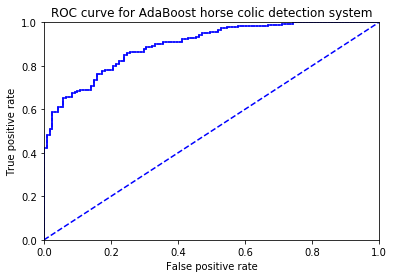

In [22]:
plotROC(aggClassEst.T, labelArr)